# Triplet Loss and Clustering


## Loading libraries

In [1]:
from fastai.vision.all import *
import umap
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [2]:
seed=42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

## Loading the Data

In [3]:
path = untar_data(URLs.CIFAR)/'train'

In [4]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2))

## UMAP of Images

<AxesSubplot:xlabel='x1', ylabel='x2'>

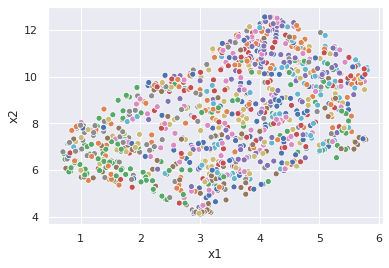

In [5]:
torch.cuda.empty_cache()

# Getting a batch of imgs and their labels
dls = data.dataloaders(path, bs=1000)
imgs, y = dls.valid.one_batch()
vcb = dls.vocab
lbls = vcb[y]

# Using Umap to embed the imgs in 2d
um = umap.UMAP().fit_transform(imgs.flatten(1).cpu())
um = pd.DataFrame(data=um, columns=['x1', 'x2'])
um['lbl'], um['y'] = lbls, y.cpu()

sns.scatterplot(data=um, x='x1', y='x2', hue='lbl', legend=False)

# Embeding and Clustering Images

## Defining Custom Loss classes

In [5]:
class TripletLoss(Module):
    def __init__(self, norm='cos', margin=0.1):
        self.margin = margin
        self.norm = norm
    
    def forward(self, embs, y):
        embs = embs.flatten(1)
        N = len(embs)
        
        if self.norm =='cos':
            # Cosine distance matrix
            nembs = embs/embs.norm(dim=1)[:,None]
            d = - nembs @ nembs.T 
        else:
            # Euclidean distance matrix
            L = embs.size()[1]
            norms = embs.square().sum(1)
            d = norms[:,None] + norms - 2*(embs@embs.T)
            d /= L
        
        with torch.no_grad():            
            # Getting indexes of the Positive and Negative sample of each Anchor
            dp, dn = d.clone(), d.clone()
            dp[y!=y[:,None]], dn[y==y[:,None]] = -np.inf, np.inf

            p = dp.argmax(1)        
            n = dn.argmin(1)
            
        return (self.margin + d[range(N),p] - d[range(N),n]).clamp(0).sum()/N
    
class MixedLoss(Module):
    def __init__(self, norm='cos', alpha=1, margin=0.05):
        self.alpha = alpha
        self.CEL = CrossEntropyLossFlat()
        self.TL = TripletLoss(norm='cos', margin=margin)   

    def forward(self, scrs, y):
        CEL = self.CEL(scrs, y)
        TL = self.TL(scrs.embs, y)
        return CEL + self.alpha*TL 

## Defining Custom Fastai/Pytorch module

In [6]:
class MyModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head
    
    def forward(self, x):
        embs = self.head[0:9](self.encoder(x))      
        scrs = self.head[9:](embs)
        scrs.embs = embs
        return scrs 
    
def my_splitter(model):
    return [params(model.encoder), params(model.head)]

def create_head(n_in, n_mid, n_out):
    return nn.Sequential(AdaptiveConcatPool2d(),
                         Flatten(),
                         nn.BatchNorm1d(n_in),
                         nn.Dropout(p=.25),
                         nn.Linear(n_in, n_in//2),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(n_in//2),
                         nn.Dropout(p=.5),
                         nn.Linear(n_in//2, n_mid),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(n_mid),
                         nn.Dropout(p=.5),
                         nn.Linear(n_mid, n_out))

## Testing the model and the loss functions

In [39]:
torch.cuda.empty_cache()
dls = data.dataloaders(path, bs=100).cpu()

encoder = create_body(resnet18, cut=-2).eval()
head = create_head(512*2, 50, 10).eval()
model = MyModel(encoder, head).eval()

imgs, y = dls.one_batch()

scrs = model(imgs)
embs = scrs.embs

In [40]:
tl = TripletLoss(norm=2, margin=0.1)
cel = CrossEntropyLossFlat()
cel(scrs, y), tl(embs, y)

(tensor(2.3148, grad_fn=<NllLossBackward>),
 tensor(0.4333, grad_fn=<DivBackward0>))

## Training

In [45]:
torch.cuda.empty_cache()
dls = data.dataloaders(path, bs=100)
path_mdls = Path('models')

norms = ['euc', 'cos']
alphas = [1]
for norm in norms:
    for n, alpha in enumerate(alphas):
        encoder, head = create_body(resnet18, cut=-2), create_head(512*2, 50, 10)
        learn = Learner(dls, 
                        MyModel(encoder, head), 
                        loss_func=MixedLoss(norm=norm, alpha=alpha), 
                        splitter=my_splitter, 
                        metrics=accuracy)

        learn.fine_tune(12)
        learn.export(path_mdls/f'{norm}{n}.pkl')
  
# learn = cnn_learner(dls, resnet18, metrics=accuracy)
# learn.fine_tune(12)
# learn.export(path_mdls/'m.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,1.370066,0.819468,0.815400,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.034338,0.621946,0.857600,00:30
1,0.888059,0.512759,0.875100,00:30
2,0.705549,0.418422,0.893200,00:31
3,0.618393,0.340990,0.912600,00:31
4,0.504800,0.313223,0.914800,00:31
5,0.487448,0.288562,0.924500,00:31
6,0.443113,0.270500,0.928700,00:31
7,0.411754,0.262631,0.929700,00:31
8,0.396691,0.252852,0.932900,00:31
9,0.391277,0.254511,0.932400,00:31


epoch,train_loss,valid_loss,accuracy,time
0,1.359043,0.814867,0.812800,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.041352,0.622758,0.856400,00:32
1,0.858889,0.499417,0.879700,00:32
2,0.715301,0.407488,0.900300,00:32
3,0.594467,0.337676,0.912500,00:32
4,0.508364,0.302750,0.918200,00:32
5,0.455128,0.283595,0.921900,00:32
6,0.447189,0.266684,0.929600,00:31
7,0.414671,0.258703,0.931200,00:31
8,0.397698,0.258397,0.931200,00:32
9,0.380419,0.248300,0.933600,00:32


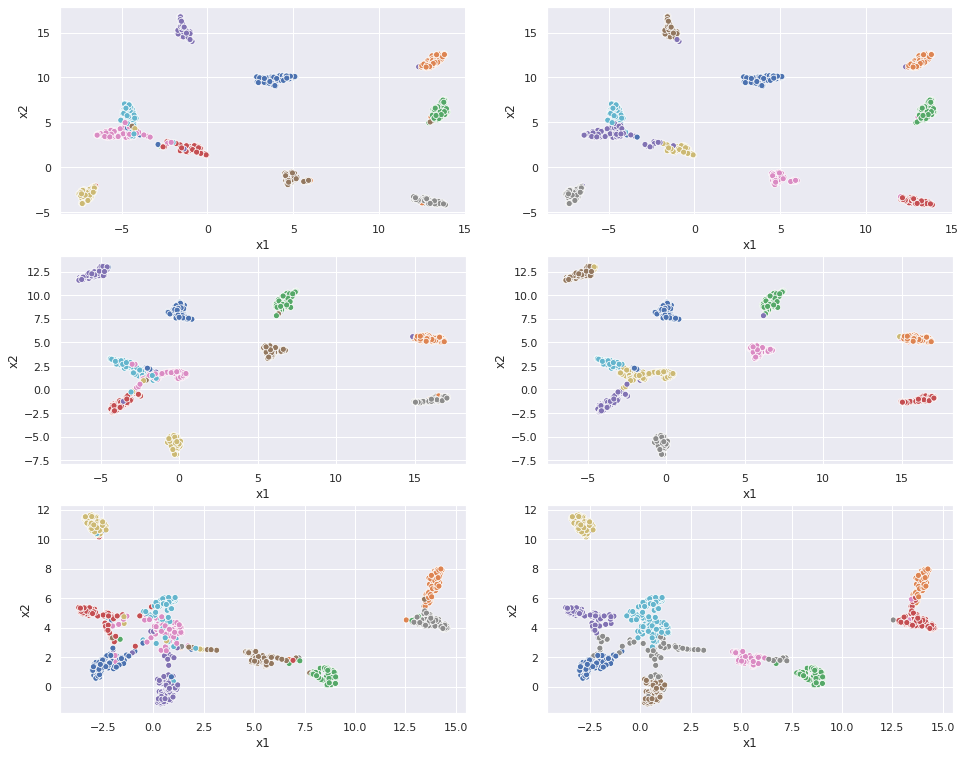

In [46]:
torch.cuda.empty_cache()
path_mdls = Path('models')
dls = data.dataloaders(path, bs=800).cpu()

imgs, y = dls.valid.one_batch()
vcb = dls.vocab
lbls = vcb[y]

seed=42
np.random.seed(seed)
alf = L(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))  # Used later to label the clusters with letters instead of numbers;
                                             # this solves a silly Seaborn bug

# mdl_names = ['alpha0','alpha1','alpha2', 'alpha3', 'm']
#mdl_names = ['cos0','cos1','cos2', 'cos3', 'm']
mdl_names = ['cos0', 'euc0', 'm']
n = len(mdl_names)
fig, axs = plt.subplots(n, 2, figsize=[16, 4.5*n])

s_scores = [] 
for name, ax in zip(mdl_names, axs):
    ## Calculating embedings
    learn = load_learner(path_mdls/(name + '.pkl'))
    m = learn.model.eval()
    with torch.no_grad():
        embs = m(imgs)
    
    ## Applying Umap dimensionality reduction
    um = umap.UMAP().fit_transform(embs.flatten(1).cpu())
    um = pd.DataFrame(data=um, columns=['x1', 'x2'])
    um['lbl'], um['y'] = lbls, y.cpu()
    
    ## Clustering    
#     preds = SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=0).fit_predict(embs.flatten(1).cpu())
    preds = AgglomerativeClustering(10).fit_predict(embs.flatten(1).cpu())
    um["Cluster"] = alf[preds] 
    s_scores.append(silhouette_score(um[['x1', 'x2']], um['Cluster']))
    
    sns.scatterplot(data=um, x='x1', y='x2', hue='lbl', ax=ax[0], legend=False)
    sns.scatterplot(data=um, x='x1', y='x2', hue='Cluster', ax=ax[1], legend=False)
    
plt.show()    

In [11]:
cl_lbl = um.groupby(['Cluster','lbl']).size().to_frame(name='Count_Val')

### Silhouette Score

In [44]:
s_scores

[0.6458782, 0.72016454, 0.60451967]

In [11]:
docs(ResBlock())

AttributeError: type object 'ResBlock' has no attribute '_docs'